<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # math functions
import pandas as pd
import scipy # scientific functions
from scipy.stats import linregress # contains linregress (for linear regression)
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit  # non-linear curve fitting
from scipy.optimize import minimize
import matplotlib.pyplot as plt # for plotting figures and setting their properties
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd # handling data structures (loaded from files)
from sklearn.metrics import r2_score # import function that calculates R^2 score
from sklearn.metrics import mean_squared_error as mse
import json, requests
import itertools
import altair as alt

## Define class and read data

In [20]:
import requests
import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as poly



class observation:
    num = 0
    Ua = 0
    Up = 0
    I = 0
    x = np.array([])
    y = np.array([])
    image = np.array([])
    group = ''
    p = 0 # polynomial approximation
    k = 0 # krivizna = 1/r, r - radius
    
    
    def __init__(self, num, group, Ua, Up, I, x, y):
        self.num = num
        self.group  = group
        self.Ua = Ua
        self.Up = Up
        self.I = I
        self.x = x
        self.y = y
        self.p = poly.Polynomial.fit(self.x, self.y, deg=3)
        
        p1 = self.p.deriv(1)
        p2 = self.p.deriv(2)
        self.k = np.abs(p2(self.x) / (1 + p1(self.x)**2) **1.5).max()
        
        
        
        
url = (r'https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Electron/main/CollectData/')

file = 'experiments.csv'
params = pd.read_csv(url + file, index_col='Num')

measurements = ''

file = 'data.txt'
text = requests.get(url+file).text.splitlines()
for line in text:
  ns, xs, ys = line.split('\t')
  if ns != '':
    num = int(ns)
    Ua = params.loc[num]['Ua']
    Up = params.loc[num]['Up']
    I = params.loc[num]['I']
    continue
  else:
    x = np.float32(xs)
    y = np.float32(ys)
  measurements += f'{num} {x} {y} {Ua} {Up} {I}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

num, x, y, Ua, Up, I = data.T

Ua = Ua*1e3 #kV
Up = Up*1e3 #kV
x = x*1e-2 # cm
y = y*1e-2 # cm

experiment = {}
for n in np.unique(num):
  filter = (num == n)
  x_ = x[filter]
  y_ = y[filter]
      
  Ua_ = Ua[filter][0]
  Up_ = Up[filter][0]
  I_  = I[filter][0]

  if (Up_ == 0) & (I_ == 0):
    group = 'Z' # Zero forces
  elif (Up_ != 0) & (I_ == 0): 
    group = 'E' # Electron in electrostatic field
  elif (Up_ == 0) & (I_ != 0): 
    group = 'B' # Electron in magnetic field
  else:
    group = 'W' # Wien filter

  obs = observation(n, group, Ua_, Up_, I_, x_, y_)
  experiment[n] = obs
  print(n, obs.group, obs.Ua, obs.Up, obs.I, obs.k)

0.0 E 500.0 -400.00000600000004 0.0 8.323590839343062
1.0 E 500.0 -600.0000239999999 0.0 6.521569269045795
2.0 E 500.0 -800.0000120000001 0.0 8.508805325169924
3.0 E 500.0 -1000.0 0.0 7.792723296881523
4.0 E 500.0 -1500.0 0.0 8.680275431092074
5.0 E 500.0 -2000.0 0.0 12.94079369728025
6.0 E 500.0 -2500.0 0.0 16.04611100388082
7.0 E 500.0 -3000.0 0.0 27.485274352891334
8.0 E 500.0 -3500.0 0.0 30.276266538099254
9.0 E 500.0 -4000.0 0.0 17.58657222271561
10.0 E 500.0 -4500.0 0.0 26.99925730572212
11.0 E 500.0 -5000.0 0.0 21.84347414288113
12.0 E 500.0 -6000.0 0.0 22.38069923591306
13.0 E 500.0 -7000.0 0.0 17.293372985893097
14.0 E 500.0 -8000.0 0.0 20.985750071418813
15.0 E 500.0 -9000.0 0.0 12.66804734331801
16.0 E 1000.0 -1000.0 0.0 9.236262156568198
17.0 E 1000.0 -1500.0 0.0 9.335203937525447
18.0 E 1000.0 -2000.0 0.0 7.948390508039983
19.0 E 1000.0 -2500.0 0.0 9.860174253500734
20.0 E 1000.0 -3000.0 0.0 18.767584146905758
21.0 E 1000.0 -3500.0 0.0 14.557430600962386
22.0 E 1000.0 -400

In [12]:
alt.data_transformers.disable_max_rows()
alt.Chart(df).mark_point().encode(
    x='x',
    y='y', 
    color='group',
    tooltip=['num', 'Ua', 'Up', 'I', 'group'] 
).interactive()

alt.Chart(...)

# Zero

Text(0.5, 1.0, 'Zero forces correction')

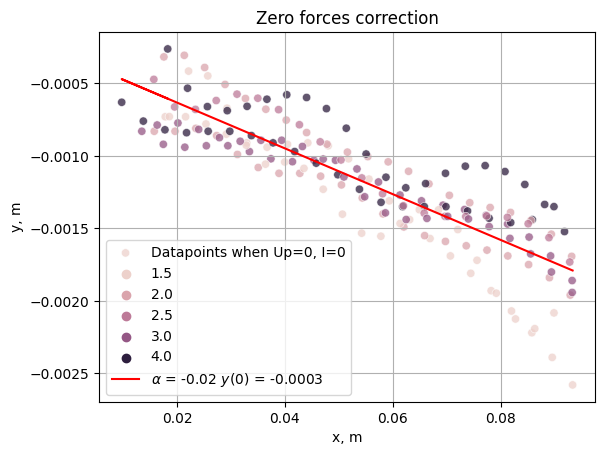

In [5]:
noforces = group==0
x_ = x[noforces]
y_ = y[noforces]
Ua_ = Ua[noforces] *1e-3
#plt.scatter(x_, y_, marker='.', color = 'gray', 
#            s=Ua_, cmap=Ua_, alpha=.3,
#            label='Datapoints when Up=0, I=0')
sns.scatterplot(x=x_, y=y_, 
            hue=Ua_, alpha=.75,
            label='Datapoints when Up=0, I=0')

fit = linregress(x_, y_)
alpha = fit.slope
plt.plot(x_, fit.intercept + fit.slope*x_, color='red', label=fr'$\alpha$ = {alpha:.2f} $y(0)$ = {fit.intercept:.4f} ')
plt.grid()
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.legend()
plt.title('Zero forces correction')


Rotate by $\alpha$ to ensure $y=0$ when no forces applied.

In [151]:
x, y = x*np.cos(alpha) + y*np.sin(alpha), -x*np.sin(alpha) + y*np.cos(alpha) 

# E-experiment

In [13]:
xmin = 4e-2
filter = (group==1) & (x > xmin) # E-experiment
d = 5.5e-2
x_ = x[filter]
y_ = y[filter]
Up_ = Up[filter]
Ua_ = Ua[filter]
 
xu = x_*x_/Ua_/4/d
yu = y_/Up_


fit = linregress(xu, yu)
k1 = fit.slope

plt.plot(xu, 1.00*xu, label=f'theory    $k_1$={1.0:.2f}',c='lightgray', ls='dotted')
plt.plot(xu, 0.75*xu, label=f'estimated $k_1$={.75:.2f}',c='gray', ls='dotted')
plt.plot(xu, fit.intercept + fit.slope*xu, 
                      label=f'fitted    $k_1$={fit.slope:.2f}',c='green')
plt.plot(xu, yu, label='measurements', c='black', 
            marker='s', fillstyle='none', ls='', alpha=.1)
plt.legend()
plt.grid()
plt.xlabel('x^2/Ua/4/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.title(r'Deflection $\frac{y}{U_P} = k_1 \frac{x^2}{4 U_A d}$');

ValueError: ignored

In [254]:
x_

array([0.07894991, 0.07597057, 0.07299223, ..., 0.0358019 , 0.03320852,
       0.03061258])

In [257]:
df1 = df[(df.group==1) & (df.x>xmin)]
df1['xu'] = df1['x']**2/df1['Ua']/4/d
df1['yu'] = df1['y']/df['Up']

alt.Chart(df1).mark_point().encode(
    x='xu',
    y='yu', 
    tooltip=['num', 'Ua', 'Up', 'I', 'x', 'y'] 
).interactive()


<ipython-input-257-2f2184b826b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['xu'] = df1['x']**2/df1['Ua']/4/d
<ipython-input-257-2f2184b826b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['yu'] = df1['y']/df['Up']


alt.Chart(...)

In [24]:
a = .8e-2 # parameter for y = r = sqrt(r^2 - (x-a)^2) equation
N = 320 # Helmholz ring coils
R = 6.7e-2 # Helmholz ring raduis
mu0 = scipy.constants.mu_0
k2 = (4/5)**1.5

# B-experiment

$$
B = \mu_0 \left({4\over 5}\right)^{3/2} {N I\over R} = k_2 \mu_0 {N I\over R}, \quad k_2 \approx 0.7155.
\tag{4}
$$

$$
{e \over m} = {2U_A\over B^2 r^2}.
\tag{5}
$$ 


In [46]:
ems = []
for i in experiment.keys():
  obs = experiment[i]
  if obs.group == 'B':
    B = k2 * mu0 * N /R * obs.I 
    r = 1/ obs.k

    em = 2*obs.Ua /(B * r)**2
    ems.append(em)
    print(f'num:{i:n}, Ua: {obs.Ua*1e-3:.1f} kV, I: {obs.I*1e3:-.0f} mA, r: {r*1e2:.1f} cm, B:{B*1e3:.3f} mT, em:{em:.2e} C/kg')
ems = np.array([ems])
ems.mean()

num:200, Ua: 1.0 kV, I: 50 mA, r: 46.0 cm, B:0.215 mT, em:2.05e+11 C/kg
num:201, Ua: 1.0 kV, I: 100 mA, r: 21.8 cm, B:0.429 mT, em:2.29e+11 C/kg
num:202, Ua: 1.0 kV, I: 150 mA, r: 13.6 cm, B:0.644 mT, em:2.62e+11 C/kg
num:203, Ua: 1.0 kV, I: 200 mA, r: 5.9 cm, B:0.859 mT, em:7.86e+11 C/kg
num:204, Ua: 1.0 kV, I: 250 mA, r: 8.6 cm, B:1.074 mT, em:2.37e+11 C/kg
num:205, Ua: 2.0 kV, I: 50 mA, r: 57.2 cm, B:0.215 mT, em:2.65e+11 C/kg
num:206, Ua: 2.0 kV, I: 100 mA, r: 23.3 cm, B:0.429 mT, em:3.98e+11 C/kg
num:207, Ua: 2.0 kV, I: 150 mA, r: 19.2 cm, B:0.644 mT, em:2.61e+11 C/kg
num:208, Ua: 2.0 kV, I: 200 mA, r: 13.7 cm, B:0.859 mT, em:2.88e+11 C/kg
num:209, Ua: 2.0 kV, I: 250 mA, r: 11.5 cm, B:1.074 mT, em:2.64e+11 C/kg
num:210, Ua: 3.0 kV, I: 50 mA, r: 59.2 cm, B:0.215 mT, em:3.71e+11 C/kg
num:211, Ua: 3.0 kV, I: 100 mA, r: 43.0 cm, B:0.429 mT, em:1.76e+11 C/kg
num:212, Ua: 3.0 kV, I: 150 mA, r: 19.8 cm, B:0.644 mT, em:3.70e+11 C/kg
num:213, Ua: 3.0 kV, I: 200 mA, r: 19.2 cm, B:0.859 mT, 

374102870957.0875

In [33]:
np.median(ems*1e-11)


2.64282237364631

In [7]:
a = 0.8*1e-2 # cm
df2 = df[df.group==2]
df2['x'] -= a 
df2['r'] = np.abs((df2['x']**2 + df2['y']**2 )/2/df2['y'])

alt.Chart(df2).mark_point().encode(
    x='x',
    y='y', 
    color='r',
    tooltip=['num', 'Ua', 'Up', 'I', 'r'] 
).interactive()

<ipython-input-7-667e34ee84e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] -= a
<ipython-input-7-667e34ee84e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['r'] = np.abs((df2['x']**2 + df2['y']**2 )/2/df2['y'])


alt.Chart(...)

In [234]:
df2[df2.num==215]


,num,x,y,Ua,Up,I,group,upa,r
4113,215.0,0.084835,0.004672,4000.0,0.0,0.053,2.0,0.0,0.772560
4114,215.0,0.081070,0.004315,4000.0,0.0,0.053,2.0,0.0,0.763727
4115,215.0,0.077305,0.003912,4000.0,0.0,0.053,2.0,0.0,0.765768
4116,215.0,0.073539,0.003485,4000.0,0.0,0.053,2.0,0.0,0.777637
4117,215.0,0.069774,0.003055,4000.0,0.0,0.053,2.0,0.0,0.798321
4118,215.0,0.066009,0.002644,4000.0,0.0,0.053,2.0,0.0,0.825299
4119,215.0,0.062244,0.002271,4000.0,0.0,0.053,2.0,0.0,0.854133
4120,215.0,0.058478,0.001938,4000.0,0.0,0.053,2.0,0.0,0.883238
4121,215.0,0.054713,0.001627,4000.0,0.0,0.053,2.0,0.0,0.920762
4122,215.0,0.050948,0.001328,4000.0,0.0,0.053,2.0,0.0,0.977960


<ipython-input-206-72203458bad3>:13: RuntimeWarning: invalid value encountered in sqrt
  return rd - np.sqrt(rd*rd - x*x)


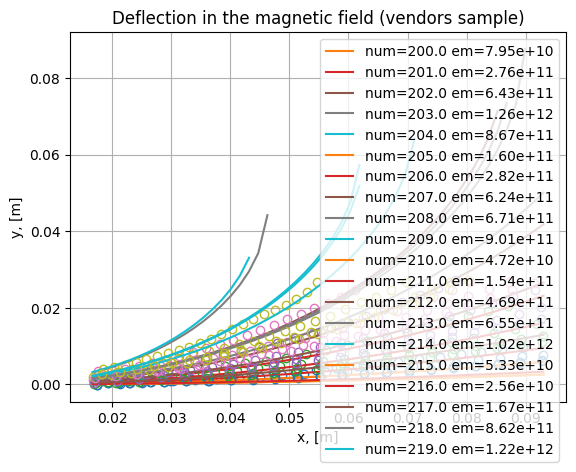

In [206]:
filter = (group==2) & (I > 0) # B-experiment
d = 5.5e-2
x_ = x[filter] - a
y_ = y[filter]
I_ = I[filter]
Ua_ = Ua[filter]
num_ = num[filter]
r = np.abs((x_**2 + y_**2)/2/y_) 
B = mu0 * k2 *N * I_/R

def circle(x, rd):
  return rd - np.sqrt(rd*rd - x*x)


xdense = np.linspace(x_.min(),x_.max(),50)

for option in np.unique(num_):
  ind = (num_==option)
  plt.plot(x_[ind], y_[ind], 
           marker='o',
           fillstyle='none', ls='')
  #popt, _ = curve_fit(circle, x_[ind], np.abs(y_[ind]) )
  #radius = popt[0]
  radius = r_[ind][-1]
  r_[ind] = radius
  B_[ind] = k2*mu0 * N *I_[ind]/R
  em_[ind] = 2*Ua_[ind]/(B_[ind]*radius)**2
  plt.plot(xdense, circle(xdense,radius),
          label=f'num={option} em={em_[ind][0]:.2e}')  
plt.legend()
plt.grid()
plt.xlabel('x, [m]')
plt.ylabel('y, [m]')
plt.title('Deflection in the magnetic field (vendors sample)');



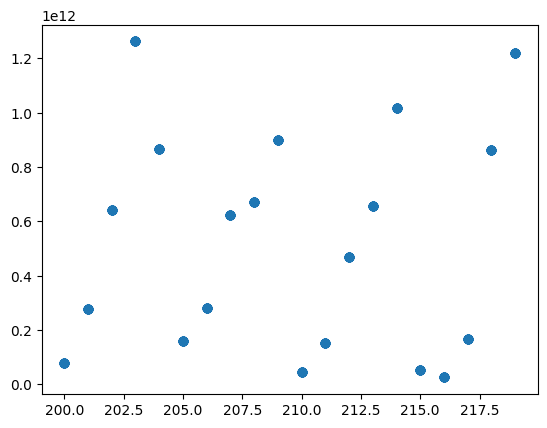

In [207]:
plt.scatter(num_, em_)

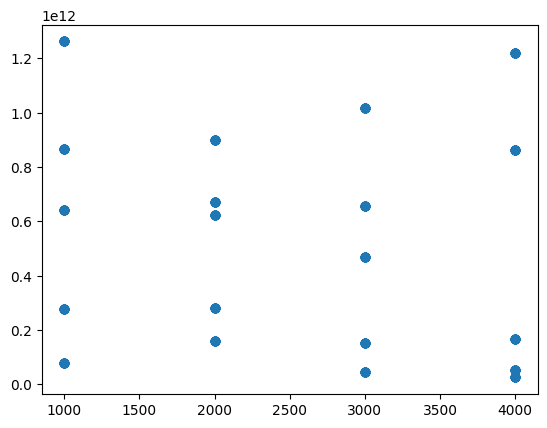

In [208]:
plt.scatter(Ua_, em_)

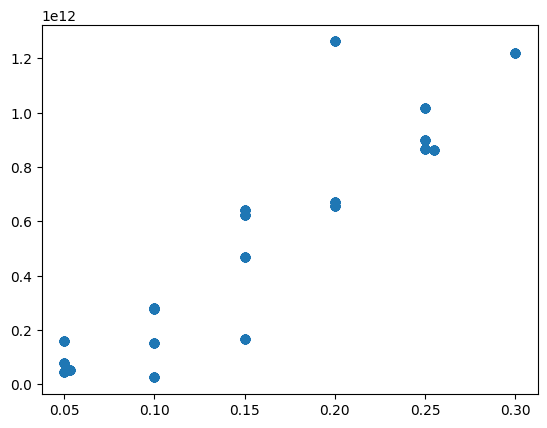

In [209]:
plt.scatter(I_, em_)

(array([10., 19., 29., 44., 46., 53., 46., 55., 50., 18., 37., 32., 30.,
        15., 11., 10., 25., 14., 18., 17., 10., 15.,  8.,  9., 11.,  6.,
         5.,  6.,  1.,  8.,  5., 13., 12.,  4.,  2.,  1.,  1.,  5.,  4.,
         1.,  3.,  4.,  5.,  4.,  4.,  7.,  3.,  3.,  1.,  3.,  2.,  1.,
         2.,  1.,  3.,  5.,  6.,  5.,  5.,  4.,  2.,  1.,  2.,  3.,  1.,
         0.,  3.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  3.4772378 ,   4.58926668,   5.70129556,   6.81332443,
          7.92535331,   9.03738219,  10.14941106,  11.26143994,
         12.37346882,  1

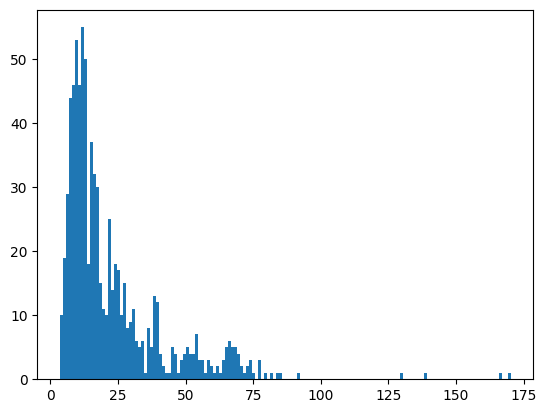

In [210]:
plt.hist(r*100, bins=150)

In [211]:
em_.mean()*1e-11

5.2171153374802826

# W-experiment

In [258]:
filter = (group==3) # w-experiment
d = 5.5e-2
x_ = x[filter] 
y_ = y[filter]
I_ = I[filter]
Ua_ = Ua[filter]
Up_ = Up[filter]
E_ = k1*Up_/d
B_ = 0.7155* mu0  *N * I_/R

em = 1/2/Ua_ * (E_/B_)**2

In [265]:
print(f'e/m:{np.unique(em).mean()*1e-11:.2f} 10^-11 C/kg')

e/m:1.21 10^-11 C/kg


In [266]:
np.unique(em)*1e-11

array([0.8227844 , 0.90664951, 0.98886425, 1.07465723, 1.07542973,
       1.0861571 , 1.11896837, 1.12114639, 1.13643383, 1.14275618,
       1.18480956, 1.1943453 , 1.23114882, 1.25405337, 1.26443887,
       1.30854747, 1.31183743, 1.32011174, 1.35997426, 1.42448834,
       1.42839009, 1.43730352, 1.6859185 ])

In [263]:
np.unique(em)/np.unique(em).mean()

array([0.67878675, 0.7479744 , 0.81580053, 0.88657866, 0.88721595,
       0.89606591, 0.92313479, 0.92493162, 0.93754357, 0.94275943,
       0.97745293, 0.9853198 , 1.01568225, 1.0345782 , 1.04314611,
       1.07953515, 1.08224933, 1.08907553, 1.12196161, 1.17518491,
       1.1784038 , 1.18575727, 1.39086149])